# Problem Description and Data Description

The goal of this Kaggle competition is to create an algorithm that can identify metastatic cancer in small image patches taken from larger digital pathology scans. Specifically, the task is to classify whether an image patch contains evidence of metastatic tissue or not.

The data for this competition consists of a large number of small pathology images. The images were extracted from larger digital pathology scans and each image is labeled as either containing metastatic tissue or not. The dataset is divided into a training set and a test set.



**Training Data:**

The training data contains 220,025 RGB images of size 96x96 pixels.
The file train_labels.csv contains the corresponding binary labels for each image, where 1 indicates the presence of metastatic tissue and 0 indicates the absence.

**Test Data:**

The test data contains 57,458 RGB images of size 96x96 pixels.
The task is to predict the binary labels for these test images.
Evaluation Metric:

The evaluation metric for this competition is the Area Under the ROC Curve (AUC). It measures the ability of the model to correctly classify the images as containing metastatic tissue or not.

# Load Libraries and Data

In [1]:
# Load libraries for project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2
from PIL import Image
import sys

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pwd

/content


In [4]:
!pip install -q kaggle


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /content/kaggle.json"

'chmod 600 /content/kaggle.json'

In [6]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [01:06<00:00, 117MB/s]
100% 6.31G/6.31G [01:07<00:00, 101MB/s]


In [19]:
os.listdir("./histopathologic-cancer-detection")

['sample_submission.csv', 'train', 'test', 'train_labels.csv']

In [8]:
!unzip -q histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

In [9]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt



In [10]:
train_dir = "histopathologic-cancer-detection/train/"
test_dir = "histopathologic-cancer-detection/test/"

train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

train_labels.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


# Exploratory Data Analysis (EDA)

In [13]:
#train_labels['label'] = train_labels['label'].astype(str)
train_labels['id'] = train_labels['id'] + '.tif'
print(train_labels.shape)

(220025, 2)


**Show some random images with their labels**

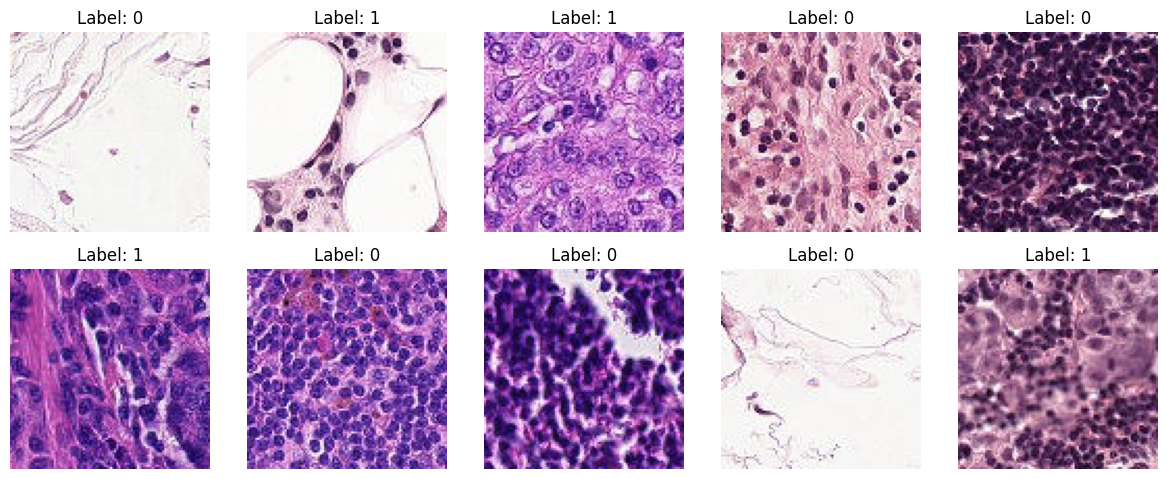

In [73]:
import random
n_images = 10
plt.figure(figsize=(12, 12))

for i in range(n_images):
    plt.subplot(5, 5, i+1)
    idx = random.randint(0, len(train_labels) - 1)  # Pick a random index
    image_path = os.path.join(train_dir, train_labels["id"][idx])
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f"Label: {train_labels['label'][idx]}")
    plt.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

In [98]:
# Basic statistics
print(f"Total Training images: {len(train_labels)}")
print(f"Positive examples: {np.sum(train_labels['label'] == 1)}")
print(f"Negative examples: {np.sum(train_labels['label'] == 0)}")

Total Training images: 220025
Positive examples: 89117
Negative examples: 130908


In [99]:
train_labels.isnull().sum()

id       0
label    0
dtype: int64

**We have no missing data, so no data imputation is required**

**Let us check distribution of label values**

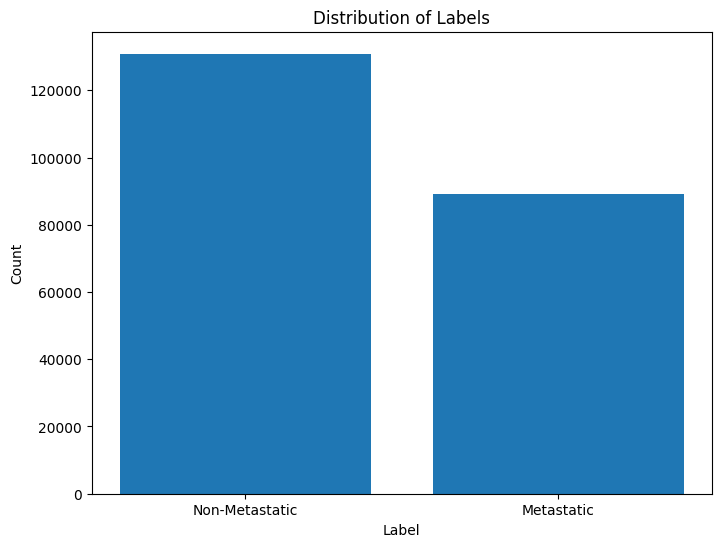

Label 0: 130908 samples (59.50%)
Label 1: 89117 samples (40.50%)


In [16]:
# Count the number of samples for each label
label_counts = train_labels['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Non-Metastatic', 'Metastatic'])
plt.show()

# Print the count and percentage of each label
total_samples = len(train_labels)
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Label {label}: {count} samples ({percentage:.2f}%)")

# Model Building

**Architecture and Reasoning**


For the Histopathologic Cancer Detection problem, the model architecture choice is important due to the intricate patterns and variability in the histopathologic images that need to be recognized for accurate classification.

CNNs are renowned for their ability to automatically and adaptively learn spatial hierarchies of features from images. This capability makes them exceptionally suitable for image classification tasks, including medical imaging.
We can also try transfer learning with some pre-trained models

For CNN:
We would start with INput layer, add some Convolutional layers and Dense layers. We can also try Dropout layers and Batch normalization to avoidf over fitting.

We would also try to vary hyperparameters such as the number of layers,  learning rate, dropout rate etc.

**Imports and Helper Functions**

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [24]:
train_labels['label'] = train_labels['label'].astype(str)
train_df, val_df = train_test_split(train_labels, test_size=0.2)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1./255)  # Rescaling

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [79]:
def show_model_accuracy(history):
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Train/Validate Accuracy over time')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show();

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)

In [127]:
df_results = pd.DataFrame(columns=['Model Name', 'AUC', 'Val AUC', 'Kaggle Private Score', 'Kaggle Public Score'])
df_results = pd.DataFrame(columns=['Model Name', 'Kaggle Private Score', 'Kaggle Public Score'])


In [128]:
def add_to_results(model_name,history, kaggle_private_score, kaggle_public_score):
    global df_results  # Declare df_results as global to modify the global instance

    # Create a dictionary for the new row
    new_row = {
        'Model Name': model_name,
        #'AUC': history.history['auc'][-1],  # Assuming you want the last epoch's value
        #'Val AUC': history.history['val_auc'][-1],  # Assuming you want the last epoch's value
        'Kaggle Private Score': kaggle_private_score,
        'Kaggle Public Score': kaggle_public_score
    }

    # Create a DataFrame from the new row
    new_rows_df = pd.DataFrame([new_row])  # Create a DataFrame directly from the dictionary

    # Append the new DataFrame to the existing df_results
    df_results = pd.concat([df_results, new_rows_df], ignore_index=True)


# Models and Results

**Model 1**

Start with some default CNN model with required layers defined in architecture earlier

In [29]:
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])


In [31]:
history1 = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)


Epoch 1/20
5501/5501 [==============================] - 163s 28ms/step - loss: 0.4257 - auc: 0.8796 - binary_accuracy: 0.8092 - val_loss: 0.3493 - val_auc: 0.9207 - val_binary_accuracy: 0.8481
Epoch 2/20
5501/5501 [==============================] - 152s 28ms/step - loss: 0.3246 - auc: 0.9321 - binary_accuracy: 0.8632 - val_loss: 0.2910 - val_auc: 0.9471 - val_binary_accuracy: 0.8810
Epoch 3/20
5501/5501 [==============================] - 152s 28ms/step - loss: 0.2809 - auc: 0.9489 - binary_accuracy: 0.8848 - val_loss: 0.2763 - val_auc: 0.9512 - val_binary_accuracy: 0.8884
Epoch 4/20
5501/5501 [==============================] - 151s 27ms/step - loss: 0.2559 - auc: 0.9575 - binary_accuracy: 0.8969 - val_loss: 0.2646 - val_auc: 0.9548 - val_binary_accuracy: 0.8932
Epoch 5/20
5501/5501 [==============================] - 150s 27ms/step - loss: 0.2341 - auc: 0.9644 - binary_accuracy: 0.9061 - val_loss: 0.2525 - val_auc: 0.9598 - val_binary_accuracy: 0.9005
Epoch 6/20
5501/5501 [=============

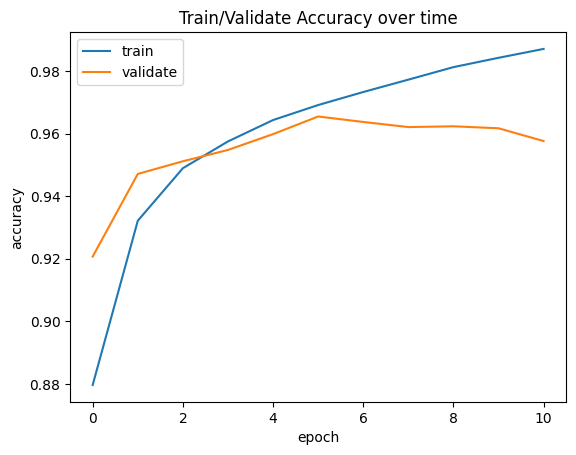

In [80]:
show_model_accuracy(history1)

In [129]:
add_to_results('Model 1 - Base CNN Model', history1, 0.8106, 0.8519)

**Model 2**

Trying to use some pre-trained model as base model

In [33]:
def create_model_with_vgg16(input_shape=(96, 96, 3)):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])
    return model


In [34]:
model2 = create_model_with_vgg16()
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
5501/5501 [==============================] - 202s 36ms/step - loss: 0.3839 - auc: 0.9022 - binary_accuracy: 0.8284 - val_loss: 0.3594 - val_auc: 0.9213 - val_binary_accuracy: 0.8420
Epoch 2/20
5501/5501 [==============================] - 196s 36ms/step - loss: 0.3402 - auc: 0.9238 - binary_accuracy: 0.8515 - val_loss: 0.3326 - val_auc: 0.9287 - val_binary_accuracy: 0.8564
Epoch 3/20
5501/5501 [==============================] - 196s 36ms/step - loss: 0.3258 - auc: 0.9302 - binary_accuracy: 0.8586 - val_loss: 0.3204 - val_auc: 0.9330 - val_binary_accuracy: 0.8603
Epoch 4/20
5501/5501 [==============================] - 196s 36ms/step - loss: 0.3160 - auc: 0.9344 - binary_accuracy: 0.8635 - val_loss: 0.3146 - val_auc: 0.9354 - val_binary_accuracy: 0.8632
Epoch 5/20
5501/5501 [==============================] - 196s 36ms/step - loss: 0.3099 - auc: 0.9370 - binary_accuracy: 0.8669 - val_loss: 0.3084 - val_auc: 0.9383 

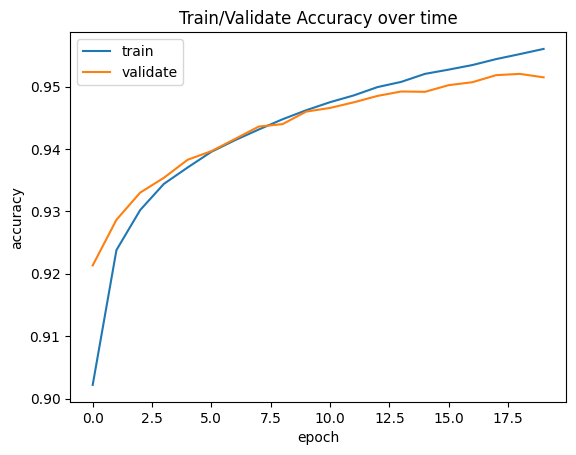

In [81]:
show_model_accuracy(history2)

There is not much over-fitting here.

In [130]:
add_to_results('Model 2 - Pre-trained Model', history2, 0.7776, 0.8022)

**Define method for creating model with some parameters**

In [55]:
from tensorflow.keras import layers, models, optimizers

def create_cnn_model(input_shape=(96, 96, 3),lr=0.001,drop_rate=0.50,normalization=False):
    # use Sequential to start empty CNN
    model = Sequential()

    # add convolutional layers
    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # add dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))

    # add dropout layer to reduce overfitting
    model.add(layers.Dropout(drop_rate))

    # use sigmoid since output is binary
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # use Adam as optimzer (recommended in the course)
    opt = optimizers.Adam(learning_rate=lr)

    # compile
    #model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])


    # build
    #model.build(input_shape=(256, 64, 64, 3))

    return model

In [63]:
from tensorflow.keras import regularizers

def create_cnn_model_2(input_shape=(96, 96, 3),lr=0.001,drop_rate=0.50,normalization=False):
    # use Sequential to start empty CNN
    model = Sequential()

    # add convolutional layers
    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # add dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

    # add dropout layer to reduce overfitting
    model.add(layers.Dropout(drop_rate))

    # use sigmoid since output is binary
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # use Adam as optimzer (recommended in the course)
    opt = optimizers.Adam(learning_rate=lr)

    # compile
    #model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])


    # build
    #model.build(input_shape=(256, 64, 64, 3))

    return model

**Model 3**

Create CNN model with default parameters defined in method like lr=0.001, drop_rate=0.50, normalization=False

In [56]:
model3 = create_cnn_model()
history3 = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 [==============================] - 157s 28ms/step - loss: 0.4193 - auc: 0.8841 - binary_accuracy: 0.8128 - val_loss: 0.3254 - val_auc: 0.9327 - val_binary_accuracy: 0.8605
Epoch 2/20
5501/5501 [==============================] - 156s 28ms/step - loss: 0.3257 - auc: 0.9316 - binary_accuracy: 0.8629 - val_loss: 0.3127 - val_auc: 0.9371 - val_binary_accuracy: 0.8701
Epoch 3/20
5501/5501 [==============================] - 153s 28ms/step - loss: 0.2937 - auc: 0.9443 - binary_accuracy: 0.8778 - val_loss: 0.2879 - val_auc: 0.9465 - val_binary_accuracy: 0.8805
Epoch 4/20
5501/5501 [==============================] - 161s 29ms/step - loss: 0.2671 - auc: 0.9538 - binary_accuracy: 0.8911 - val_loss: 0.2920 - val_auc: 0.9467 - val_binary_accuracy: 0.8777
Epoch 5/20
5501/5501 [==============================] - 163s 30ms/step - loss: 0.2448 - auc: 0.9612 - binary_accuracy: 0.9011 - val_loss: 0.2811 - val_auc: 0.9506 - val_binary_accuracy: 0.8876
Epoch 6/20
5501/5501 [=============

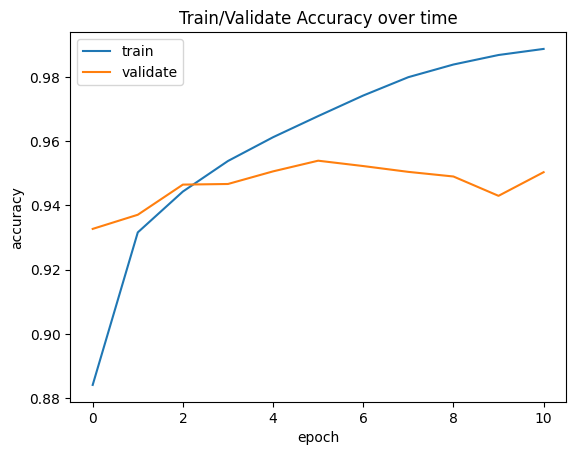

In [82]:
show_model_accuracy(history3)

In [131]:
add_to_results('Model 3 - Modified CNN Model', history3, 0.8041, 0.8437)

**Model 4**

Create CNN model with parameters lr=0.001, drop_rate=0.50, **normalization=True**

In [58]:
model4 = create_cnn_model(normalization=True)
history4 = model4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)


Epoch 1/20
5501/5501 [==============================] - 160s 28ms/step - loss: 0.4245 - auc: 0.8959 - binary_accuracy: 0.8287 - val_loss: 1.0209 - val_auc: 0.8098 - val_binary_accuracy: 0.7583
Epoch 2/20
5501/5501 [==============================] - 154s 28ms/step - loss: 0.3248 - auc: 0.9351 - binary_accuracy: 0.8682 - val_loss: 0.3387 - val_auc: 0.9435 - val_binary_accuracy: 0.8558
Epoch 3/20
5501/5501 [==============================] - 155s 28ms/step - loss: 0.2828 - auc: 0.9503 - binary_accuracy: 0.8877 - val_loss: 0.3009 - val_auc: 0.9482 - val_binary_accuracy: 0.8740
Epoch 4/20
5501/5501 [==============================] - 156s 28ms/step - loss: 0.2568 - auc: 0.9585 - binary_accuracy: 0.8988 - val_loss: 0.3750 - val_auc: 0.9346 - val_binary_accuracy: 0.8677
Epoch 5/20
5501/5501 [==============================] - 152s 28ms/step - loss: 0.2351 - auc: 0.9650 - binary_accuracy: 0.9076 - val_loss: 0.3020 - val_auc: 0.9422 - val_binary_accuracy: 0.8820
Epoch 6/20
5501/5501 [=============

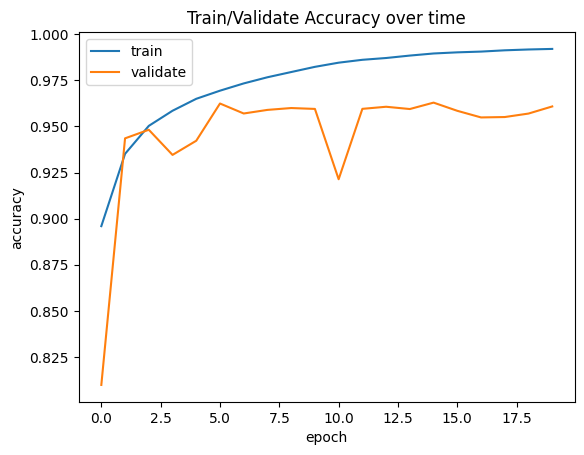

In [83]:
show_model_accuracy(history4)

In [132]:
add_to_results('Model 4 - CNN Model - Normalized', history4, 0.8216, 0.8711)

**Model 5**

Create CNN model with parameters lr=0.001, **drop_rate=0.30**, normalization=True

In [60]:
model5 = create_cnn_model(drop_rate=0.30, normalization=True)
history5 = model5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 [==============================] - 167s 30ms/step - loss: 0.4104 - auc: 0.8977 - binary_accuracy: 0.8330 - val_loss: 0.3545 - val_auc: 0.9194 - val_binary_accuracy: 0.8553
Epoch 2/20
5501/5501 [==============================] - 164s 30ms/step - loss: 0.3078 - auc: 0.9402 - binary_accuracy: 0.8778 - val_loss: 0.3007 - val_auc: 0.9474 - val_binary_accuracy: 0.8766
Epoch 3/20
5501/5501 [==============================] - 163s 30ms/step - loss: 0.2656 - auc: 0.9551 - binary_accuracy: 0.8962 - val_loss: 0.7020 - val_auc: 0.8033 - val_binary_accuracy: 0.7285
Epoch 4/20
5501/5501 [==============================] - 158s 29ms/step - loss: 0.2371 - auc: 0.9640 - binary_accuracy: 0.9076 - val_loss: 0.2556 - val_auc: 0.9601 - val_binary_accuracy: 0.9039
Epoch 5/20
5501/5501 [==============================] - 158s 29ms/step - loss: 0.2166 - auc: 0.9700 - binary_accuracy: 0.9165 - val_loss: 0.3132 - val_auc: 0.9556 - val_binary_accuracy: 0.8824
Epoch 6/20
5501/5501 [=============

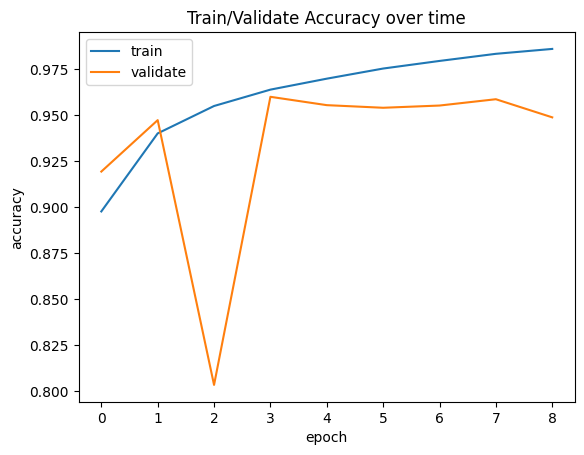

In [84]:
show_model_accuracy(history5)

**Model 6**

Create CNN model with parameters **lr=0.0001**, drop_rate=0.50, normalization=True

In [61]:
model6 = create_cnn_model(lr=0.0001, normalization=True)
history6 = model6.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 [==============================] - 169s 30ms/step - loss: 0.4134 - auc: 0.8883 - binary_accuracy: 0.8195 - val_loss: 0.3691 - val_auc: 0.9233 - val_binary_accuracy: 0.8404
Epoch 2/20
5501/5501 [==============================] - 163s 30ms/step - loss: 0.3434 - auc: 0.9241 - binary_accuracy: 0.8547 - val_loss: 0.3282 - val_auc: 0.9398 - val_binary_accuracy: 0.8644
Epoch 3/20
5501/5501 [==============================] - 163s 30ms/step - loss: 0.3144 - auc: 0.9369 - binary_accuracy: 0.8685 - val_loss: 0.3095 - val_auc: 0.9432 - val_binary_accuracy: 0.8705
Epoch 4/20
5501/5501 [==============================] - 161s 29ms/step - loss: 0.2893 - auc: 0.9468 - binary_accuracy: 0.8812 - val_loss: 0.2958 - val_auc: 0.9476 - val_binary_accuracy: 0.8784
Epoch 5/20
5501/5501 [==============================] - 160s 29ms/step - loss: 0.2681 - auc: 0.9542 - binary_accuracy: 0.8895 - val_loss: 0.2798 - val_auc: 0.9524 - val_binary_accuracy: 0.8844
Epoch 6/20
5501/5501 [=============

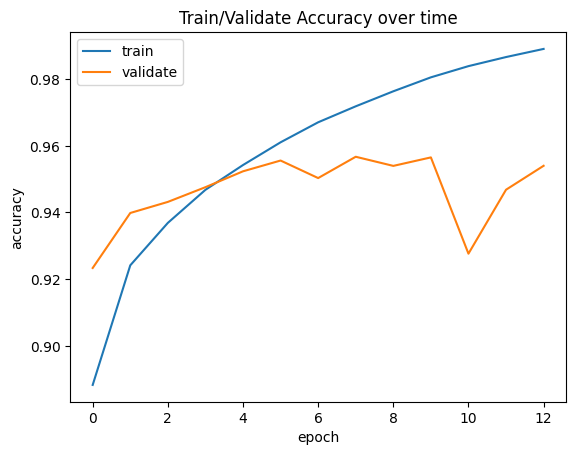

In [85]:
show_model_accuracy(history6)

In [133]:
add_to_results('Model 6 - Lerarning Rate Reduced', history6, 0.7475, 0.8341)

**Model 7**

Create CNN model with parameters lr=0.001, drop_rate=0.50, normalization=True.
**Added regularization to this method**

In [64]:
model7 = create_cnn_model_2(normalization=True)
history7 = model7.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 [==============================] - 164s 29ms/step - loss: 0.6670 - auc: 0.8936 - binary_accuracy: 0.8280 - val_loss: 0.5979 - val_auc: 0.9131 - val_binary_accuracy: 0.7999
Epoch 2/20
5501/5501 [==============================] - 161s 29ms/step - loss: 0.4911 - auc: 0.9321 - binary_accuracy: 0.8676 - val_loss: 1.0975 - val_auc: 0.7638 - val_binary_accuracy: 0.6800
Epoch 3/20
5501/5501 [==============================] - 161s 29ms/step - loss: 0.4377 - auc: 0.9419 - binary_accuracy: 0.8804 - val_loss: 0.4506 - val_auc: 0.9520 - val_binary_accuracy: 0.8761
Epoch 4/20
5501/5501 [==============================] - 162s 29ms/step - loss: 0.4178 - auc: 0.9469 - binary_accuracy: 0.8872 - val_loss: 0.5482 - val_auc: 0.9265 - val_binary_accuracy: 0.8240
Epoch 5/20
5501/5501 [==============================] - 172s 31ms/step - loss: 0.4043 - auc: 0.9494 - binary_accuracy: 0.8902 - val_loss: 0.4094 - val_auc: 0.9499 - val_binary_accuracy: 0.8840
Epoch 6/20
5501/5501 [=============

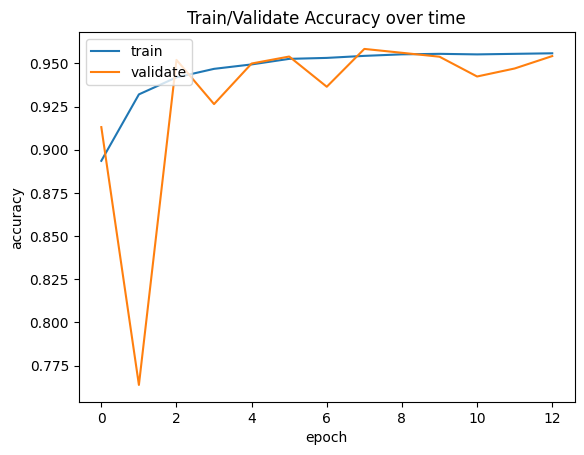

In [86]:
show_model_accuracy(history7)

In [134]:
add_to_results('Model 7 - Added Regularization', history7, 0.8123, 0.8412)

In [89]:
callback8 = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)
model8 = create_cnn_model_2(normalization=True)
history8 = model8.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback8]
)



Epoch 1/20
5501/5501 [==============================] - 178s 32ms/step - loss: 0.6712 - auc: 0.8959 - binary_accuracy: 0.8318 - val_loss: 0.7732 - val_auc: 0.8702 - val_binary_accuracy: 0.7309
Epoch 2/20
5501/5501 [==============================] - 178s 32ms/step - loss: 0.4874 - auc: 0.9360 - binary_accuracy: 0.8729 - val_loss: 0.5312 - val_auc: 0.9060 - val_binary_accuracy: 0.8282
Epoch 3/20
5501/5501 [==============================] - 176s 32ms/step - loss: 0.4307 - auc: 0.9459 - binary_accuracy: 0.8848 - val_loss: 0.7193 - val_auc: 0.8831 - val_binary_accuracy: 0.8271
Epoch 4/20
5501/5501 [==============================] - 175s 32ms/step - loss: 0.4058 - auc: 0.9502 - binary_accuracy: 0.8914 - val_loss: 0.8951 - val_auc: 0.8611 - val_binary_accuracy: 0.8374
Epoch 5/20
5501/5501 [==============================] - 179s 32ms/step - loss: 0.3832 - auc: 0.9534 - binary_accuracy: 0.8947 - val_loss: 2.3168 - val_auc: 0.7338 - val_binary_accuracy: 0.7489
Epoch 6/20
5501/5501 [=============

In [135]:
add_to_results('Model 8 - Changed Early Stopping', history8, 0.8189, 0.8342)

In [35]:
# retrieve list of file
file_list = os.listdir(test_dir)

# generate empty dataframe
test_df = pd.DataFrame({'id':file_list})

In [38]:
# remove the file extension in the id column
test_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])


In [ ]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

In [36]:
# image generator for the test set
test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96,96),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [87]:
def save_submission(model, submission_filename):
    # generate empty dataframe
    test_df = pd.DataFrame({'id':file_list})
    # remove the file extension in the id column
    test_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])

    predictions = model.predict(test_generator, verbose=1)
    # let's rearrange the predictions
    predictions = np.transpose(predictions)[0]
    # fill the prediction in the label column
    test_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

    test_df.to_csv(submission_filename, index=False)
    files.download(submission_filename)


In [47]:
save_submission(model2, 'submission2_cnn.csv')

57458/57458 [==============================] - 253s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
save_submission(model3, 'submission3_cnn.csv')

57458/57458 [==============================] - 120s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
save_submission(model4, 'submission4_cnn.csv')

57458/57458 [==============================] - 127s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
save_submission(model6, 'submission6_cnn.csv')

57458/57458 [==============================] - 125s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
save_submission(model7, 'submission7_cnn.csv')

57458/57458 [==============================] - 134s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
save_submission(model8, 'submission8_cnn.csv')

57458/57458 [==============================] - 135s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis


We tried various changes to model architecture like different layers and tried hyperparametyers tuning like Epochs, early stopping, learning rate and drop rate. This helped us to get to better results for one model. Some of these modifications did not help. After Model#4, we were not able to imrove score.

In [136]:
print(df_results)

                         Model Name  Kaggle Private Score  Kaggle Public Score
0          Model 1 - Base CNN Model                0.8106               0.8519
1       Model 2 - Pre-trained Model                0.7776               0.8022
2      Model 3 - Modified CNN Model                0.8041               0.8437
3  Model 4 - CNN Model - Normalized                0.8216               0.8711
4  Model 6 - Lerarning Rate Reduced                0.7475               0.8341
5    Model 7 - Added Regularization                0.8123               0.8412
6  Model 8 - Changed Early Stopping                0.8189               0.8342


**Best Model**

Most model trials had quite similar results but Model#4 had best Kaggle score. This was the model where we added **BatchNormalization**.

In [137]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, None, None, 16)    448       
                                                                 
 batch_normalization (Batch  (None, None, None, 16)    64        
 Normalization)                                                  
                                                                 
 conv2d_18 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 batch_normalization_1 (Bat  (None, None, None, 16)    64        
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPooli  (None, None, None, 16)    0         
 ng2D)                                                           
                                                      

# Conclusion

* I learned a lot about model building with CNN for medical image detection problem
* Learned about experimenting with various layers and hyperparameters. Adding BatchNormalization imroved the performance but changing learning rate did not help much for this problem/dataset
* In future, I would like to try changing number of neurons and adding augmented data
* Rather than just trying manually changing parameters, I would like to try to grid search

Overall, results looked good with selected model.